In [54]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [55]:
fashion_mnist_train = FashionMNIST(
    root="FashionMNIST", train=True, download=True, transform=transforms.ToTensor()
)

In [56]:
fashion_mnist_test = FashionMNIST(
    root="FashionMNIST", train=False, download=True, transform=transforms.ToTensor()
)

In [57]:
batch_size = 128

train_dataloader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

In [58]:
print(train_dataloader)
print(test_dataloader)

In [59]:
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


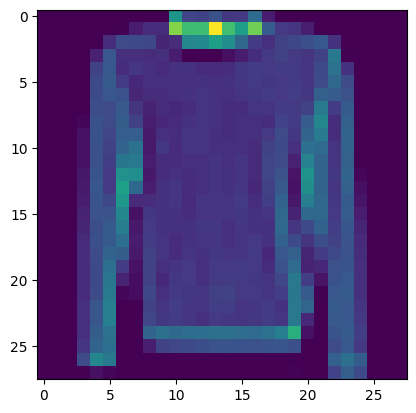

In [60]:
import matplotlib.pyplot as plt

plt.imshow(images[0][0])
plt.show()

In [61]:
labels[0]

tensor(2)

In [62]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [63]:
classes[labels[0].item()]

'Pullover'

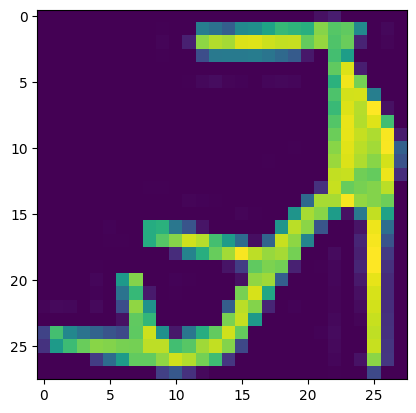

In [64]:
import matplotlib.pyplot as plt

plt.imshow(images[1][0])
plt.show()

In [65]:
labels[1]

tensor(5)

In [66]:
classes[labels[1].item()]

'Sandal'

torch.Size([128, 1, 28, 28])
torch.Size([128])


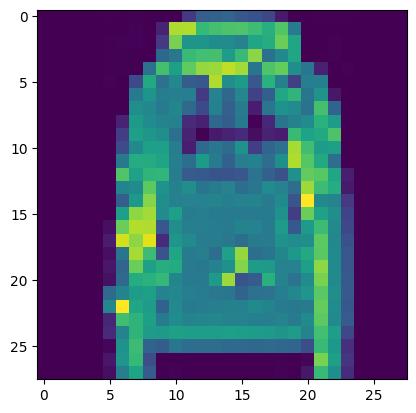

Pullover


In [67]:
images, labels = next(iter(test_dataloader))
print(images.shape)
print(labels.shape)

import matplotlib.pyplot as plt

plt.imshow(images[1][0])
plt.show()

print(classes[labels[1].item()])

In [68]:
import torch.nn as nn
import torch.optim as optim
import torch

In [69]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0
            ),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 畳み込み層→全結合層への渡し方
        self.dense = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size()[0], -1)
        out = self.dense(out)

        return out

In [70]:
net = CNN()

In [71]:
fake = torch.FloatTensor(8, 1, 28, 28)
net(fake).shape

torch.Size([8, 10])

In [72]:
net(images[0].unsqueeze(0))

tensor([[-0.0148,  0.1087, -0.0825, -0.0235,  0.0835,  0.0048,  0.0687,  0.0616,
          0.0070,  0.0333]], grad_fn=<AddmmBackward0>)

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [74]:
net = net.to(device)

In [75]:
images = images.to(device)
labels = labels.to(device)

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 20
batch_size = 128

In [77]:
import time
from tqdm import tqdm

train_losses = []
train_accs = []
val_losses = []
val_accs = []

start = time.time()

for epoch in tqdm(range(epochs)):
    # 訓練モード
    net.train()

    train_loss = 0
    train_acc = 0

    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # 推論
        outputs = net(images)
        loss = criterion(outputs, labels)
        # 微分
        loss.backward()
        # 重み更新
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 評価モード
    net.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_dataloader.dataset)
        avg_val_acc = val_acc / len(test_dataloader.dataset)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

    end = time.time() - start
    print(f"Epoch[{epoch + 1}/{epochs}]")
    print(f"train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f},")
    print(f"train_acc: {avg_train_acc:.4f}, val_acc: {avg_val_acc:.4f},")
    print(f"{end} sec.")

  5%|▌         | 1/20 [00:05<01:40,  5.31s/it]

Epoch[1/20]
train_loss: 0.0049, val_loss: 0.0036,
train_acc: 0.7639, val_acc: 0.8351,
5.311962366104126 sec.


 10%|█         | 2/20 [00:10<01:36,  5.35s/it]

Epoch[2/20]
train_loss: 0.0030, val_loss: 0.0029,
train_acc: 0.8622, val_acc: 0.8679,
10.694860935211182 sec.


 15%|█▌        | 3/20 [00:16<01:31,  5.38s/it]

Epoch[3/20]
train_loss: 0.0026, val_loss: 0.0027,
train_acc: 0.8800, val_acc: 0.8820,
16.115224361419678 sec.


 20%|██        | 4/20 [00:21<01:25,  5.36s/it]

Epoch[4/20]
train_loss: 0.0023, val_loss: 0.0026,
train_acc: 0.8931, val_acc: 0.8857,
21.435117959976196 sec.


 25%|██▌       | 5/20 [00:26<01:20,  5.35s/it]

Epoch[5/20]
train_loss: 0.0022, val_loss: 0.0027,
train_acc: 0.9006, val_acc: 0.8766,
26.768484115600586 sec.


 30%|███       | 6/20 [00:32<01:14,  5.33s/it]

Epoch[6/20]
train_loss: 0.0020, val_loss: 0.0025,
train_acc: 0.9046, val_acc: 0.8896,
32.051799058914185 sec.


 35%|███▌      | 7/20 [00:37<01:09,  5.33s/it]

Epoch[7/20]
train_loss: 0.0019, val_loss: 0.0026,
train_acc: 0.9106, val_acc: 0.8897,
37.37402701377869 sec.


 40%|████      | 8/20 [00:42<01:03,  5.30s/it]

Epoch[8/20]
train_loss: 0.0018, val_loss: 0.0024,
train_acc: 0.9164, val_acc: 0.8942,
42.624977827072144 sec.


 45%|████▌     | 9/20 [00:47<00:58,  5.28s/it]

Epoch[9/20]
train_loss: 0.0017, val_loss: 0.0025,
train_acc: 0.9210, val_acc: 0.8920,
47.860841274261475 sec.


 50%|█████     | 10/20 [00:53<00:53,  5.32s/it]

Epoch[10/20]
train_loss: 0.0016, val_loss: 0.0025,
train_acc: 0.9274, val_acc: 0.8905,
53.26603627204895 sec.


 55%|█████▌    | 11/20 [00:58<00:47,  5.33s/it]

Epoch[11/20]
train_loss: 0.0015, val_loss: 0.0023,
train_acc: 0.9298, val_acc: 0.8999,
58.60420370101929 sec.


 60%|██████    | 12/20 [01:03<00:42,  5.34s/it]

Epoch[12/20]
train_loss: 0.0014, val_loss: 0.0026,
train_acc: 0.9331, val_acc: 0.8939,
63.9658260345459 sec.


 65%|██████▌   | 13/20 [01:09<00:37,  5.33s/it]

Epoch[13/20]
train_loss: 0.0013, val_loss: 0.0027,
train_acc: 0.9367, val_acc: 0.8929,
69.26812601089478 sec.


 70%|███████   | 14/20 [01:14<00:31,  5.33s/it]

Epoch[14/20]
train_loss: 0.0013, val_loss: 0.0026,
train_acc: 0.9393, val_acc: 0.9010,
74.6131317615509 sec.


 75%|███████▌  | 15/20 [01:19<00:26,  5.29s/it]

Epoch[15/20]
train_loss: 0.0012, val_loss: 0.0027,
train_acc: 0.9422, val_acc: 0.8944,
79.79259014129639 sec.


 80%|████████  | 16/20 [01:25<00:21,  5.29s/it]

Epoch[16/20]
train_loss: 0.0011, val_loss: 0.0027,
train_acc: 0.9479, val_acc: 0.8948,
85.09269380569458 sec.


 85%|████████▌ | 17/20 [01:30<00:15,  5.31s/it]

Epoch[17/20]
train_loss: 0.0011, val_loss: 0.0030,
train_acc: 0.9505, val_acc: 0.8903,
90.43617463111877 sec.


 90%|█████████ | 18/20 [01:35<00:10,  5.33s/it]

Epoch[18/20]
train_loss: 0.0010, val_loss: 0.0029,
train_acc: 0.9523, val_acc: 0.8959,
95.81529688835144 sec.


 95%|█████████▌| 19/20 [01:41<00:05,  5.33s/it]

Epoch[19/20]
train_loss: 0.0009, val_loss: 0.0031,
train_acc: 0.9554, val_acc: 0.8919,
101.13529634475708 sec.


100%|██████████| 20/20 [01:46<00:00,  5.32s/it]

Epoch[20/20]
train_loss: 0.0009, val_loss: 0.0032,
train_acc: 0.9577, val_acc: 0.8928,
106.4389533996582 sec.
